# Early fusion: Modeling

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/'
output_path = '../out/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Load, prepare, and fuse data

#### Load

In [4]:
train_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_late_fusion_train.csv'))
test_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_late_fusion_test.csv'))

train_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_late_fusion_train.csv'))
test_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_late_fusion_test.csv'))

In [5]:
train_video_df

,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,target
0,0.015628,0.006488,0.332302,0.005860,0.010791,0.027581,0.008047,0.090256,0.071395,0.000000,0.025372,0.071558,0.016837,0.021930,0.100884,0.078326,0.033349,9
1,0.060160,0.018400,0.071560,0.012000,0.242040,0.448360,0.007160,0.178640,0.223600,0.070760,0.046840,0.195360,0.022360,0.030200,0.302520,0.184840,0.033280,6
2,0.010410,0.004974,0.000000,0.001692,0.000000,0.000923,0.004769,0.000000,0.000000,0.000769,0.009590,0.045436,0.008872,0.003744,0.102821,0.044410,0.052308,17
3,0.049892,0.014378,0.000000,0.012757,0.097784,0.007676,0.012270,0.227838,0.178811,0.031838,0.026432,0.105946,0.017892,0.026649,0.145568,0.054919,0.021784,1
4,0.042857,0.022122,0.000000,0.005143,0.237265,0.022245,0.005714,0.414041,0.399224,0.147796,0.029224,0.060490,0.027224,0.032163,0.250857,0.057265,0.024980,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.009926,0.012370,0.174222,0.001407,0.081778,0.043556,0.011556,0.346444,0.047556,0.000593,0.025259,0.042519,0.004222,0.004741,0.030519,0.049259,0.025556,13
940,0.016655,0.007069,0.001034,0.006552,0.381552,0.370655,0.012862,0.222931,0.541034,0.010931,0.022897,0.045828,0.032621,0.010069,0.054690,0.053517,0.013897,11
941,0.022275,0.008980,0.119961,0.004588,0.112745,0.154353,0.010510,0.240745,0.064745,0.105294,0.026196,0.056784,0.008471,0.011059,0.128980,0.135137,0.011490,12
942,0.039120,0.017640,0.056240,0.009320,0.000000,0.010640,0.024320,0.033000,0.017040,0.000720,0.014400,0.069840,0.014880,0.020720,0.172640,0.122720,0.117920,3


In [6]:
train_audio_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,target
0,32.25328,0.248346,28.48594,32.81652,38.77012,10.284180,54.80582,29.32340,65.10525,7.753541,...,-0.003858,0.222840,2.312139,1.759531,0.303333,0.502615,0.245000,0.086362,-25.07678,9
1,35.31089,0.169806,31.82989,36.88577,39.76237,7.932484,91.53120,30.14883,35.22653,22.054080,...,-0.001485,0.157199,3.000000,1.546392,0.536667,0.244586,0.130000,0.010000,-24.96124,6
2,15.00466,0.197219,13.08473,14.17712,15.54830,2.463572,141.89270,58.63279,65.23180,94.959310,...,-0.008247,0.569787,5.154639,6.417112,0.082500,0.057609,0.084286,0.039949,-30.61435,17
3,27.19199,0.203668,22.02517,28.73136,31.81585,9.790684,227.96290,207.72190,168.91290,140.438400,...,-0.007626,0.676697,7.142857,3.731344,0.218000,0.165336,0.050000,0.024495,-23.59847,1
4,31.61772,0.191328,23.65003,34.24127,35.96895,12.318920,217.99010,174.03710,72.39302,45.165160,...,-0.008659,0.161784,4.232804,1.630435,0.423333,0.247835,0.250000,0.210000,-22.89440,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,42.95848,0.052166,42.54087,43.39946,44.34895,1.808083,-23.52892,20.86910,25.16865,9.025725,...,-0.004952,0.006405,1.612903,0.854701,0.700000,0.000000,0.220000,0.060000,-30.89702,13
940,39.34763,0.056474,36.90495,39.02785,41.35905,4.454098,109.80310,143.63800,25.63460,14.213470,...,-0.004029,0.063755,2.654867,1.357466,0.463333,0.272070,0.187500,0.168430,-23.13163,11
941,20.42394,0.173671,17.51854,20.13378,23.58605,6.067514,126.42300,139.79460,60.51228,14.411540,...,-0.009290,0.503957,3.381643,2.970297,0.135000,0.114273,0.178333,0.097025,-33.31668,12
942,37.54728,0.087142,35.04800,38.44248,39.93583,4.887836,155.41510,148.31160,38.30656,11.224160,...,-0.009982,0.025049,3.045686,1.041667,0.540000,0.050000,0.263333,0.159652,-26.46734,3


#### Normalization

In [7]:
from sklearn import preprocessing
# WARNING: Video data is already normalized

# eGeMAPS dataset normalization
# load the model from disk
file_path = os.path.join(input_path,'audio','egemaps','min_max_scaler_egemaps_audio.sav')
min_max_scaler = pickle.load(open(file_path, 'rb'))

X = train_audio_df.drop(columns=['target'])                                 # Get features from train dataset
X_scaled = min_max_scaler.transform(X)                                  # Fit and transform features (train)
X_train_audio_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list()) # Create a dataframe from normalized features



X = test_audio_df.drop(columns=['target'])                                  # Get features from test dataset
X_scaled = min_max_scaler.transform(X)                                      # Transform features (test)
X_test_audio_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())  # Create a dataframe from normalized features

#### Fuse data

In [8]:
train_df = pd.concat([X_train_audio_df,train_video_df], axis=1)
test_df  = pd.concat([X_test_audio_df,test_video_df], axis=1)

#### Other functions

In [9]:
from sklearn.metrics import confusion_matrix

def plot_save_conf_matrix(X_test, y_test, clf, title, file_name, report=False):
    scores = clf.predict_proba(X_test_db)           # Predict probabilities
    AUC_test = roc_auc_score(y_true=y_test_db,
                             y_score=scores,
                             average='macro',
                             multi_class='ovo')  # Get AUC score
    print('AUC (test):', AUC_test)
    
    y_pred = clf.predict(X_test_db)
    conf_mat = confusion_matrix(y_test_db, y_pred, normalize='true')
    df_cm = pd.DataFrame(conf_mat, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))
    
    fig=plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')
    plt.show()
    

## Early Fusion Pipelines

### Elastic Net

In [9]:
from sklearn.linear_model import SGDClassifier


# Create new variables to split the train dataset into k folds
X = train_df.drop(columns='target')
y = train_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
alpha_values    = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 1]
loss_values     = ['log', 'modified_huber']
l1_ratio_values = np.arange(0.05, 1.05, 0.05).tolist()
parameters      = [(alpha,loss,l1_ratio)  
                   for alpha in alpha_values
                   for loss in loss_values
                   for l1_ratio in l1_ratio_values
                  ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create new classifier and fit it (train dataset)
        clf = SGDClassifier(penalty      = 'elasticnet',
                            alpha        = parameters[i][0],
                            loss         = parameters[i][1],
                            l1_ratio     = parameters[i][2],
                            random_state = seed,
                            n_jobs       = -1,
                            class_weight = class_weight
                           )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)           # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')  # Get AUC score
        AUC_avg += AUC_tmp                          # Add new AUC
    
    AUC_avg /= n_folds                              # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # Loss
                    parameters[i][2],               # L1_ratio
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','Loss','L1_ratio','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_elastic_net_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)


# Train model with the parameters of the best model  (using full training set)    
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(train_df.target), y=train_df.target)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = SGDClassifier(penalty      = 'elasticnet',
                           alpha        = params_best_model[0],
                           loss         = params_best_model[1],
                           l1_ratio     = params_best_model[2],
                           random_state = seed,
                           n_jobs       = -1,
                           class_weight = class_weight
                          )
best_model.fit(train_df.drop(columns='target'), train_df.target)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_elastic_net.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 400/400 [12:20<00:00,  1.85s/it]


SGDClassifier(alpha=0.0001, average=False,
              class_weight={0: 2.2801932367149758, 1: 0.7712418300653595,
                            2: 2.2801932367149758, 3: 0.7827529021558872,
                            4: 2.2801932367149758, 5: 0.7827529021558872,
                            6: 0.7827529021558872, 7: 2.2801932367149758,
                            8: 0.7827529021558872, 9: 0.7827529021558872,
                            10: 0.7712418300653595, 11: 0.7827529021558872,
                            12: 2.2801932367149758, 13: 0.7827529021558872,
                            14: 0.7827529021558872, 15: 0.7827529021558872,
                            16: 2.2801932367149758, 17: 0.7827529021558872},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.3, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=24, shuffle=True

In [10]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,Penalty,Alpha,Loss,L1_ratio,AUC_avg
85,elasticnet,0.0001,log,0.30,0.882318
84,elasticnet,0.0001,log,0.25,0.882159
83,elasticnet,0.0001,log,0.20,0.881971
88,elasticnet,0.0001,log,0.45,0.881780
122,elasticnet,0.0010,log,0.15,0.881623


AUC (test): 0.893242411036915


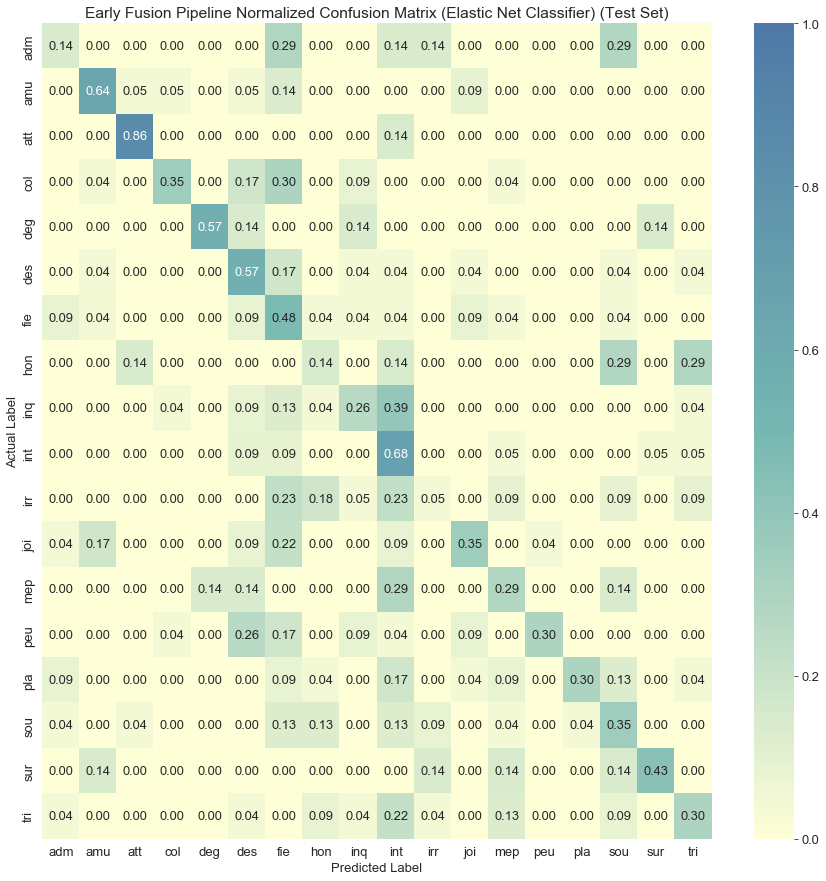

In [10]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
X_test_db = test_df.drop(columns=['target'])
y_test_db = test_df.target


# load the model from disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_elastic_net.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Elastic Net Classifier) (Test Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_elastic_net.svg'
                     )

### kNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier


# Create new variables to split the train dataset into k folds
X = train_df.drop(columns='target')
y = train_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_neigh_values   = np.arange(50, 405, 5).tolist()
leaf_size_values = np.arange(30, 310, 5).tolist()
weights_values   = ['uniform', 'distance']
parameters = [(n_neigh,leaf_size,weights)  
              for n_neigh in n_neigh_values
              for leaf_size in leaf_size_values
              for weights in weights_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Create a new classifier and fit it (train dataset)
        clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                   leaf_size    = parameters[i][1],
                                   weights      = parameters[i][2],
                                   n_jobs       = -1
                                  )
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_neighbors
                    parameters[i][1],                 # leaf_size
                    parameters[i][2],                 # weights
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_knn_'+str(n_folds)+'_fold_cv.csv') , index=None, header=True)



# Train model with the parameters of the best model  (using full training set)    
best_model = KNeighborsClassifier(n_neighbors  = params_best_model[0],
                                  leaf_size    = params_best_model[1],
                                  weights      = params_best_model[2],
                                  n_jobs       = -1
                                 )
best_model.fit(train_df.drop(columns='target'), train_df.target)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_knn.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 7952/7952 [3:04:30<00:00,  1.39s/it]  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=75, p=2,
                     weights='distance')


In [13]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,k_neighbors,leaf_size,weights,AUC_avg
597,75,120,distance,0.837459
579,75,75,distance,0.837459
641,75,230,distance,0.837459
575,75,65,distance,0.837459
639,75,225,distance,0.837459


AUC (test): 0.8490010649596174


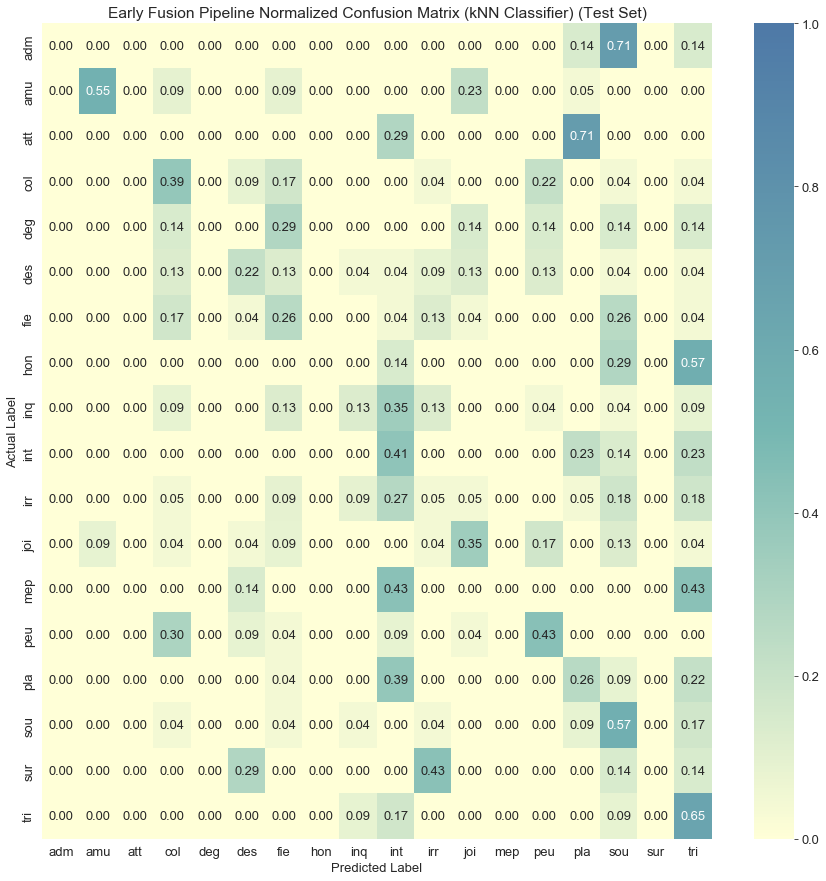

In [11]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
X_test_db = test_df.drop(columns=['target'])
y_test_db = test_df.target


# load the model from disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_knn.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (kNN Classifier) (Test Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_knn.svg'
                     )

### Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier


# Create new variables to split the train dataset into k folds
X = train_df.drop(columns='target')
y = train_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 18)] #list(range(1,len(X.columns)))
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Create a new classifier and fit it (train dataset)
        clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                     splitter          = parameters[i][1],
                                     max_depth         = parameters[i][2],
                                     min_samples_split = parameters[i][3],
                                     min_samples_leaf  = parameters[i][4],
                                     max_features      = parameters[i][5],
                                     random_state      = seed,
                                     class_weight      = class_weight
                                  )
        clf.fit(X_train,y_train)
        

        scores = clf.predict_proba(X_val)             # Predict probabilities
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_tree_'+str(n_folds)+'_fold_cv.csv') , index=None, header=True)


# Train model with the parameters of the best model
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(train_df.target), y=train_df.target)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = DecisionTreeClassifier(criterion         = params_best_model[0],
                                    splitter          = params_best_model[1],
                                    max_depth         = params_best_model[2],
                                    min_samples_split = params_best_model[3],
                                    min_samples_leaf  = params_best_model[4],
                                    max_features      = params_best_model[5],
                                    random_state      = seed,
                                    class_weight      = class_weight
                                  )
best_model.fit(train_df.drop(columns='target'), train_df.target)    # Fit model (full train dataset)

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_tree.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 36000/36000 [7:56:13<00:00,  1.26it/s]  


DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.7827529021558872,
                                     14: 0.7827529021558872,
                                     15: 0.78275290215588

In [10]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features,AUC_avg
18009,entropy,best,5,0.1,0.1,56,0.744968
25209,entropy,best,45,0.1,0.1,56,0.744968
21609,entropy,best,25,0.1,0.1,56,0.744968
19809,entropy,best,15,0.1,0.1,56,0.744968
24309,entropy,best,40,0.1,0.1,56,0.744968


AUC (test): 0.7468841492030163


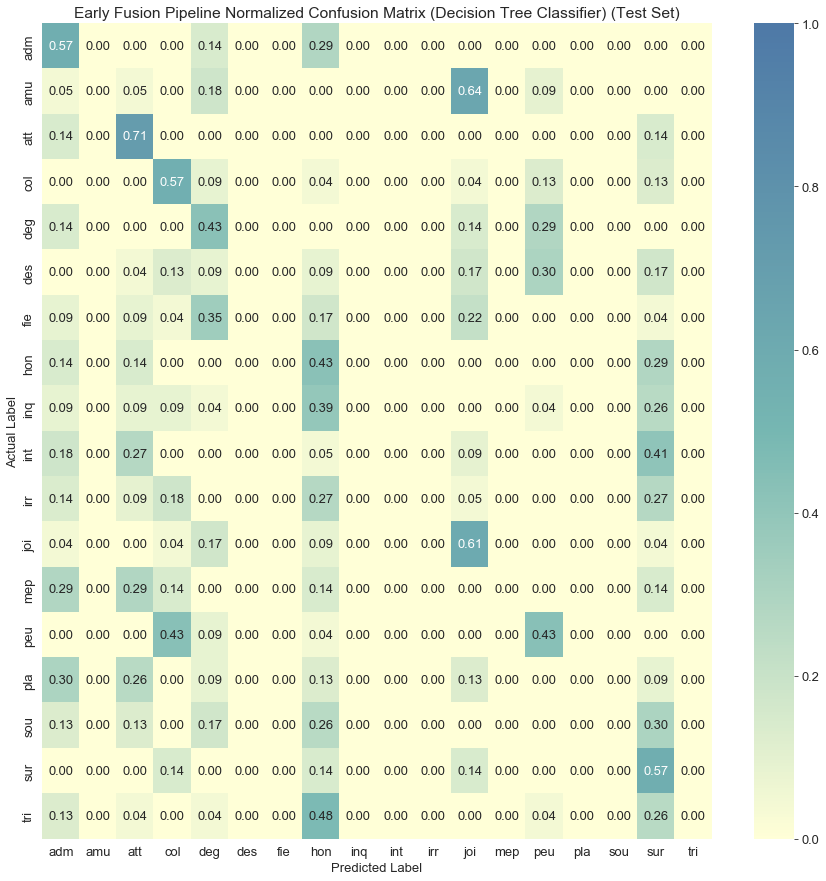

In [12]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
X_test_db = test_df.drop(columns=['target'])
y_test_db = test_df.target


# load the model from disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_tree.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Decision Tree Classifier) (Test Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_tree.svg'
                     )

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample


# Create new variables to split the train dataset into k folds
X = train_df.drop(columns='target')
y = train_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define parameters to evaluate
n_estimators_values      = [int(x) for x in np.linspace(10, 500, num = 100)]#np.arange(100, 810, 10).tolist()
criterion_values         = ['gini']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters = [(n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap)  
              for n_estimators in n_estimators_values
              for criterion in criterion_values
              for max_features in max_features_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for bootstrap in bootstrap_values
             ]
#print(len(parameters))

# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=5000, replace=False, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    clf = RandomForestClassifier(n_estimators      = parameters[i][0],
                                 criterion         = parameters[i][1],
                                 max_features      = parameters[i][2],
                                 max_depth         = parameters[i][3],
                                 min_samples_split = parameters[i][4],
                                 min_samples_leaf  = parameters[i][5],
                                 bootstrap         = parameters[i][6],
                                 random_state      = seed,
                                 n_jobs            = -1
                                )
    AUC_avg = 0 # Initialize average AUC
    for train_idx, val_idx in skf.split(X, y): 
        X_train, X_val, y_train, y_val = X.iloc[train_idx], X.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        # Modify classifier class weight and fit the model (train dataset)
        clf.class_weight = class_weight
        clf.fit(X_train,y_train)
        
        # Compute results (validation dataset)
        scores = clf.predict_proba(X_val)             # Predict probability
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')    # Get AUC score
        AUC_avg += AUC_tmp                            # Add new AUC score
    
    AUC_avg /= n_folds                                # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_estimators
                    parameters[i][1],                 # criterion
                    parameters[i][2],                 # max_features
                    parameters[i][3],                 # max_depth
                    parameters[i][4],                 # min_samples_split
                    parameters[i][5],                 # min_samples_leaf
                    parameters[i][6],                 # bootstrap
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                  # Update best average AUC
        params_best_model = parameters[i]             # Update best model parameters

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['n_estimators','criterion','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_early_fusion_clf_rf_'+str(n_folds)+'_fold_cv.csv') , index=None, header=True)



# Train model with the parameters of the best model
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(train_df.target), y=train_df.target)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_model = RandomForestClassifier(n_estimators      = params_best_model[0],
                                    criterion         = params_best_model[1],
                                    max_features      = params_best_model[2],
                                    max_depth         = params_best_model[3],
                                    min_samples_split = params_best_model[4],
                                    min_samples_leaf  = params_best_model[5],
                                    bootstrap         = params_best_model[6],
                                    class_weight      = class_weight,
                                    random_state      = seed,
                                    n_jobs            = -1
                                   )
best_model.fit(train_df.drop(columns='target'), train_df.target)    # Fit model

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_rf.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_model)

100%|██████████| 5000/5000 [9:26:30<00:00,  6.80s/it]   


RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.78...
                                     15: 0.7827529021558872,
                                     16: 2.280193236

In [13]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,n_estimators,criterion,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap,AUC_avg
1563,495,gini,sqrt,20.0,2,1,False,0.905751
4407,490,gini,auto,20.0,2,1,False,0.905630
3978,435,gini,sqrt,20.0,2,1,False,0.905325
4976,445,gini,auto,70.0,2,1,False,0.905140
1383,445,gini,auto,30.0,2,1,False,0.905140


AUC (test): 0.9320479537980058


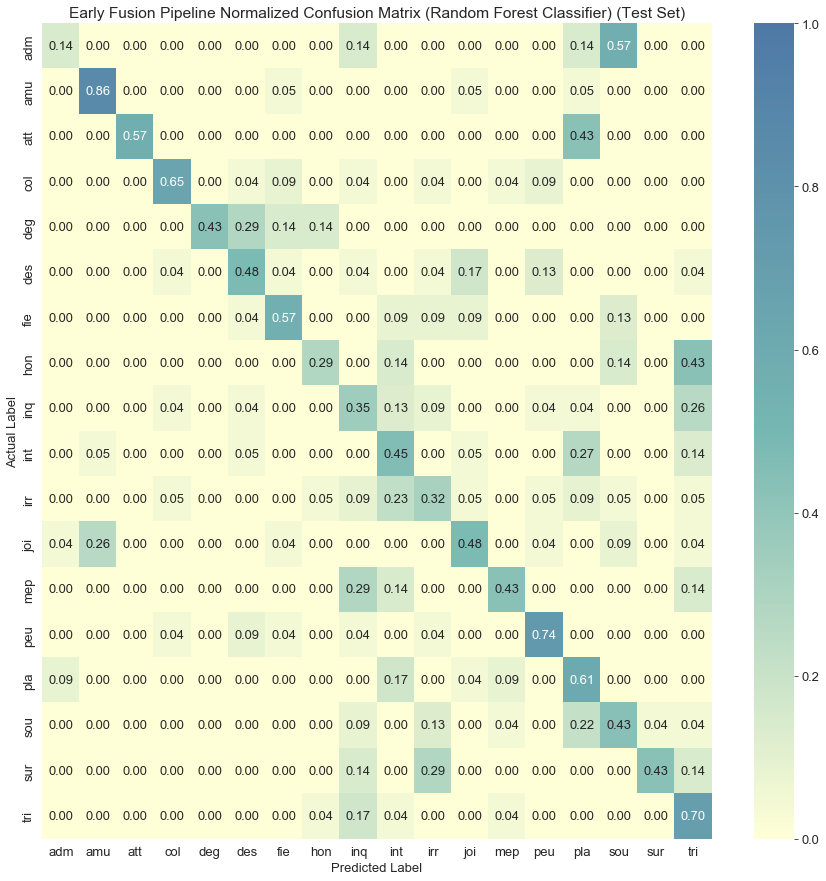

In [13]:
from sklearn.metrics import confusion_matrix

# Get test features and labels from the dataset
X_test_db = test_df.drop(columns=['target'])
y_test_db = test_df.target


# load the model from disk
file_path = os.path.join(output_path,'models','pipeline_early_fusion_clf_rf.sav')
clf = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_test    = X_test_db,
                      y_test    = y_test_db,
                      clf       = clf,
                      title     = 'Early Fusion Pipeline Normalized Confusion Matrix (Random Forest Classifier) (Test Set)',
                      file_name = 'conf_mat_pipeline_early_fusion_clf_rf.svg',
                      report    = True
                     )